# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.3 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 4.9 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-vv89mjye
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-vv89mjye
  Resolved https://github.com/huggingface/accelerate to commit 0b5ac0253ec7fb795f2ddab47ce94b2881719b4c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.23.0.dev0-py3-none-any.whl size=255798 sha256=632eeac071bd7e83680734d2a81ff68ffe420e34d66ac6179053e4ecc35c2bb6
  Stored in directory: /tmp/pip-ephem-wheel-cache-dqgyutt9/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.22.0
    Uninstalling accelerate-0.22.0:
      Successfully uninstalled accelerate-0.22.0


In [4]:
# !pip install huggingface_hub

# Load data and pre-processing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [7]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
train_p = pd.read_csv("/content/drive/MyDrive/data/train_p.csv")
test_p = pd.read_csv('/content/drive/MyDrive/data/test_p.csv')

train_r = pd.read_csv("/content/drive/MyDrive/data/train_r.csv")
test_r = pd.read_csv('/content/drive/MyDrive/data/test_r.csv')

In [9]:
train_r=train_r.drop(['Unnamed: 0'],axis=1)
train_p=train_p.drop(['Unnamed: 0'],axis=1)

test_r=test_r.drop(['Unnamed: 0'],axis=1)
test_p=test_p.drop(['Unnamed: 0'],axis=1)

In [10]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

In [11]:
failure=train_r[(train_r['label']=='failure')] #606
introduction=train_r[(train_r['label']=='introduction')]
implementation=train_r[(train_r['label']=='implementation')] # 493
clarification=train_r[(train_r['label']=='clarification')] #282

In [12]:
failure_action=train_p[(train_p['label']=='failure action')] #330
perception=train_p[(train_p['label']=='perception')] #152
information=train_p[(train_p['label']=='information')] #250

In [13]:
train_r=pd.concat([failure[:606] , introduction, implementation[:493], clarification[:282],train_r])
train_p=pd.concat([failure_action[:330] , perception[:152], information[:250],train_p])

In [34]:
from sklearn.utils import shuffle
train_p = shuffle(train_p)
train_r = shuffle(train_r)

# Model

In [14]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [15]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [16]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['text'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [17]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [18]:
import torch
torch.cuda.empty_cache()

In [19]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Researcher

In [35]:
valid_r, test_r = train_test_split(test_r, test_size=0.5, random_state=42)

In [36]:
train_data_loader_r = create_data_loader(train_r, tokenizer, max_len=128, batch_size=16)
val_data_loader_r = create_data_loader(valid_r, tokenizer, max_len=128, batch_size=16)
test_data_loader_r = create_data_loader(test_r, tokenizer, max_len=128, batch_size=16)

In [37]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [38]:
# define parameters
EPOCHS = 20

model = Classifier(len(R_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_r) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_r))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [39]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader_r)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 1.2255642509886198 accuracy 0.531039640987285


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 0.9547863714396954 accuracy 0.026551982049364247

Epoch 2/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.5658586157397145 accuracy 0.8089005235602094


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 1.3169026258401573 accuracy 0.02468212415856395

Epoch 3/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.18037601622165225 accuracy 0.9495138369483919


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 1.7161151891341433 accuracy 0.02356020942408377

Epoch 4/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.08965598299567189 accuracy 0.9786836200448765


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 1.8799810194468591 accuracy 0.02580403889304413

Epoch 5/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.043352079884720125 accuracy 0.9887808526551982


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 1.965231010777643 accuracy 0.026551982049364247

Epoch 6/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.025893845281513807 accuracy 0.9947643979057591


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.146512270657695 accuracy 0.026551982049364247

Epoch 7/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.009671298582924507 accuracy 0.9981301421091997


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.2462388144740544 accuracy 0.02617801047120419

Epoch 8/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.009570339153946233 accuracy 0.9977561705310396


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.3080205575897708 accuracy 0.02617801047120419

Epoch 9/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.006303308413234412 accuracy 0.9985041136873597


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.375103589867649 accuracy 0.02617801047120419

Epoch 10/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.004823464439791029 accuracy 0.9981301421091997


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.5760654104306013 accuracy 0.025430067314884067

Epoch 11/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.003227283661111696 accuracy 0.9985041136873597


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.505645489458402 accuracy 0.02505609573672401

Epoch 12/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.003742010475304726 accuracy 0.9985041136873597


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.57945916589415 accuracy 0.02580403889304413

Epoch 13/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.0032777986393955957 accuracy 0.9988780852655198


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.624823717513209 accuracy 0.02580403889304413

Epoch 14/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.002551214480176679 accuracy 0.9992520568436799


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.639125874873571 accuracy 0.025430067314884067

Epoch 15/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.002985119475505642 accuracy 0.9992520568436799


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.581000393933209 accuracy 0.02580403889304413

Epoch 16/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.003954778305905208 accuracy 0.9988780852655198


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.6051764177609584 accuracy 0.02617801047120419

Epoch 17/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.0026054644989753364 accuracy 0.9992520568436799


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.629928505833959 accuracy 0.02580403889304413

Epoch 18/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.002146641099898261 accuracy 0.9992520568436799


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.6374948909142404 accuracy 0.025430067314884067

Epoch 19/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.0024846738971020734 accuracy 0.9992520568436799


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.6393646812266525 accuracy 0.025430067314884067

Epoch 20/20
----------


  0%|          | 0/168 [00:00<?, ?it/s]

Train loss 0.0024378914370442673 accuracy 0.9992520568436799


  0%|          | 0/8 [00:00<?, ?it/s]

Val loss 2.638435668330203 accuracy 0.02580403889304413



In [40]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader_r)

In [41]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.5936578600651827

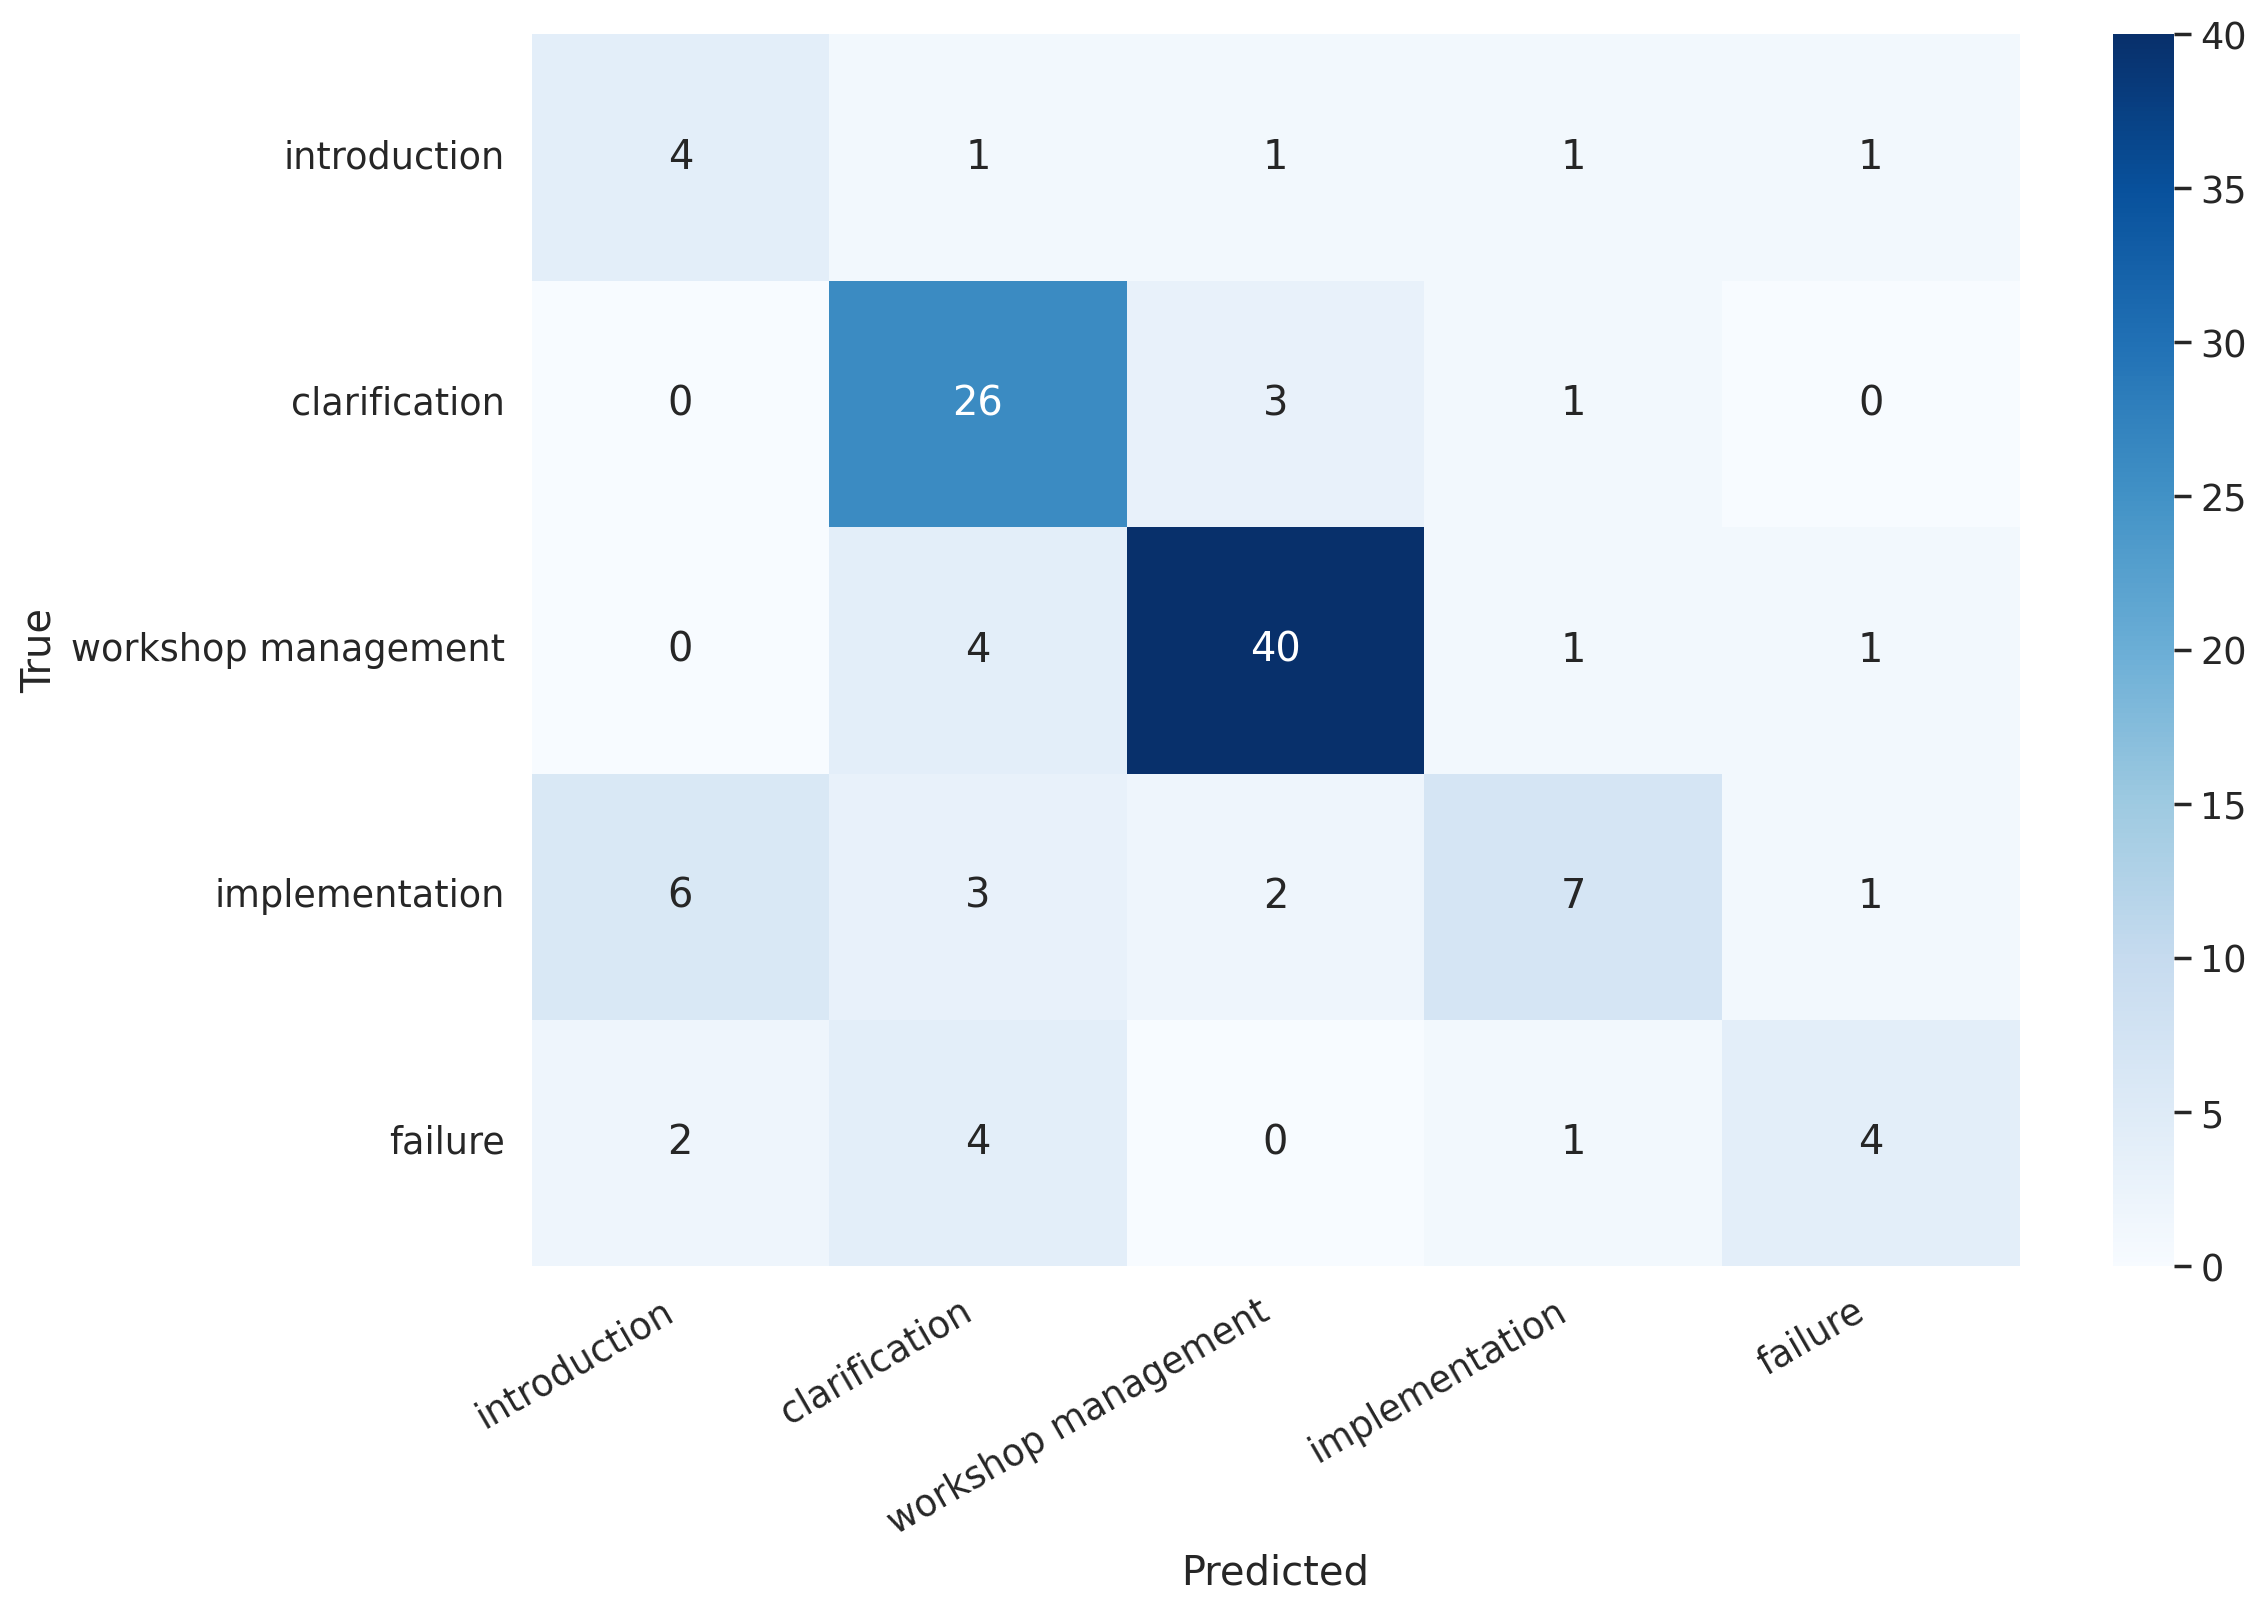

In [42]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [43]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.33      0.50      0.40         8
      clarification       0.68      0.87      0.76        30
workshop management       0.87      0.87      0.87        46
     implementation       0.64      0.37      0.47        19
            failure       0.57      0.36      0.44        11

           accuracy                           0.71       114
          macro avg       0.62      0.59      0.59       114
       weighted avg       0.72      0.71      0.70       114



# Participant

In [44]:
valid_p, test_p = train_test_split(test_p, test_size=0.5, random_state=42)

In [45]:
train_data_loader_p = create_data_loader(train_p, tokenizer, max_len=128, batch_size=16)
val_data_loader_p = create_data_loader(valid_p, tokenizer, max_len=128, batch_size=16)
test_data_loader_p = create_data_loader(test_p, tokenizer, max_len=128, batch_size=16)

In [46]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [47]:
# define parameters
EPOCHS = 20

model = Classifier(len(P_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_p) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

P_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_p))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [48]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = P_model_train.train_epoch(train_data_loader_p)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = P_model_train.eval_model(val_data_loader_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.4814918987891252 accuracy 0.35461741424802107


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 1.2684455315272014 accuracy 0.023746701846965697

Epoch 2/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.9791146904981437 accuracy 0.6031662269129288


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 1.4215393861134846 accuracy 0.021108179419525065

Epoch 3/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.5166007332002917 accuracy 0.8052770448548813


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 1.638455222050349 accuracy 0.024274406332453827

Epoch 4/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.275857188590184 accuracy 0.9134564643799472


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 1.9820837378501892 accuracy 0.022163588390501317

Epoch 5/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.09185826008114181 accuracy 0.9741424802110817


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 2.5300400455792746 accuracy 0.023746701846965697

Epoch 6/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.030890205082632287 accuracy 0.9926121372031662


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 2.9391070206960044 accuracy 0.022691292875989446

Epoch 7/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.013009842840794223 accuracy 0.9973614775725593


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 3.3991249998410544 accuracy 0.02321899736147757

Epoch 8/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.006335572797429411 accuracy 0.9989445910290237


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 3.0983069936434426 accuracy 0.025857519788918204

Epoch 9/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.005260824183532342 accuracy 0.9984168865435356


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 3.552427430947622 accuracy 0.022163588390501317

Epoch 10/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.002981203986809221 accuracy 0.9989445910290237


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 3.764020403226217 accuracy 0.022163588390501317

Epoch 11/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.002398200172925086 accuracy 0.9994722955145119


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 3.6136406858762107 accuracy 0.023746701846965697

Epoch 12/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.0030110664836898006 accuracy 0.9989445910290237


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 3.881644546985626 accuracy 0.02163588390501319

Epoch 13/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.003342005329552897 accuracy 0.9989445910290237


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 4.062500437100728 accuracy 0.02163588390501319

Epoch 14/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.0036910070452942836 accuracy 0.9989445910290237


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 4.072823723157247 accuracy 0.02163588390501319

Epoch 15/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.0019903002032166848 accuracy 0.9994722955145119


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 4.016123294830322 accuracy 0.02163588390501319

Epoch 16/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.0019229122643220089 accuracy 0.9994722955145119


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 4.009882688522339 accuracy 0.02163588390501319

Epoch 17/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.0022335954781126685 accuracy 0.9994722955145119


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 4.014153242111206 accuracy 0.02163588390501319

Epoch 18/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.0018080598155003308 accuracy 0.9994722955145119


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 3.975661277770996 accuracy 0.02163588390501319

Epoch 19/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.0022641058547516204 accuracy 0.9994722955145119


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 3.973641335964203 accuracy 0.02163588390501319

Epoch 20/20
----------


  0%|          | 0/119 [00:00<?, ?it/s]

Train loss 0.0023816072142598837 accuracy 0.9994722955145119


  0%|          | 0/6 [00:00<?, ?it/s]

Val loss 3.975477655728658 accuracy 0.02163588390501319



In [49]:
y_texts, y_pred, y_pred_probs, y_test = P_model_train.get_predictions(test_data_loader_p)

In [50]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.3998095238095238

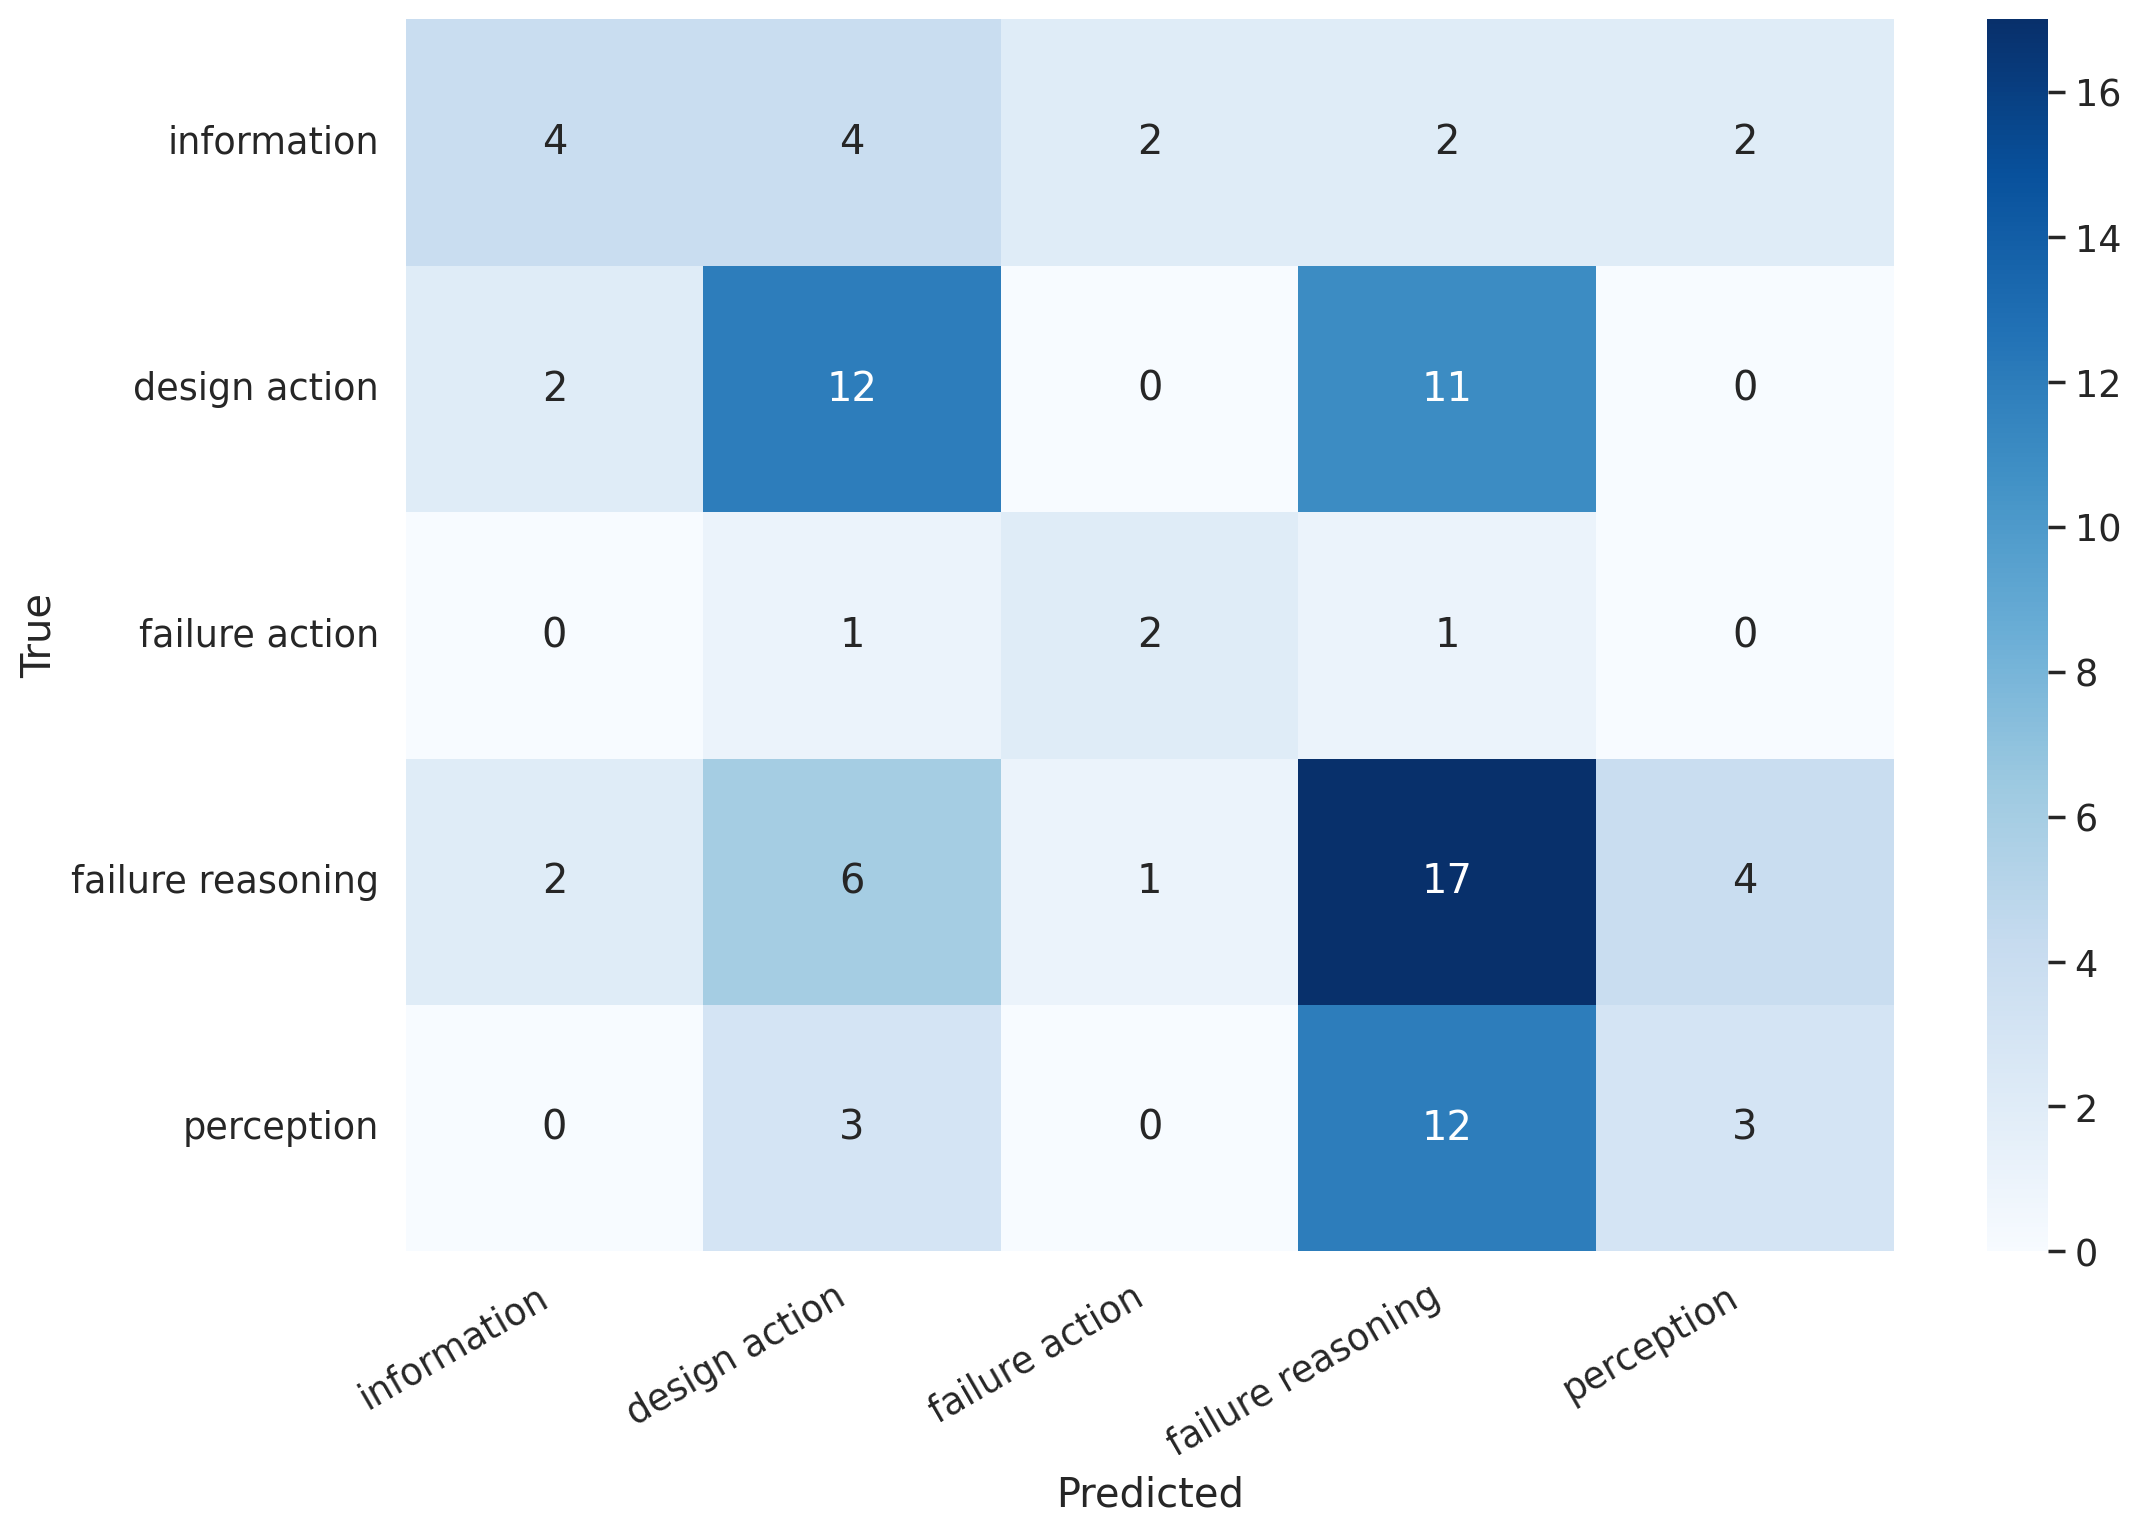

In [51]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [52]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.50      0.29      0.36        14
    design action       0.46      0.48      0.47        25
   failure action       0.40      0.50      0.44         4
failure reasoning       0.40      0.57      0.47        30
       perception       0.33      0.17      0.22        18

         accuracy                           0.42        91
        macro avg       0.42      0.40      0.39        91
     weighted avg       0.42      0.42      0.40        91

